In [ ]:
# 1. Install standard libraries
!pip install awkward vector pytorch-lightning


import torch
print(f"GPU Available: {torch.cuda.is_available()}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 909.5/909.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 656.7/656.7 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 36.3 MB/s eta 0:00:00
  Cloning https://github.com/minyoungg/vqtorch.git to /tmp/pip-req-build-1vznfv41
  Running command git clone --filter=blob:none --quiet https://github.com/minyoungg/vqtorch.git /tmp/pip-req-build-1vznfv41
  Resolved https://github.com/minyoungg/vqtorch.git to commit 02e60a19bd742c17b0bf3e1925f23796d54cbeac
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.4 MB/s eta 0:00:00
  Created wheel for vqtorch: filename=vqtorch-0.1.0-py3-none-any.whl size=17825 sha256=f42d3d7468c31f25ac3f5d5601b39e7b3947075c992167edb560343ed56b89e9
  Stored in dir

In [2]:
import torch
import awkward as ak
import vector
import numpy as np

def generate_synthetic_data(num_jets=1000, max_particles=30):
    """
    Creates fake jet data mimicking JetClass structure.
    Output:
    - x_continuous: The physics numbers (pt, eta, phi) for the Model Input
    - y_labels: Fake binary labels (0 or 1) for the Model Target
    """
    print(f"Generating {num_jets} synthetic jets...")

    # 1. Create random physics values (pT, eta, phi)
    # Shape: [Batch, Sequence, Features]
    x_continuous = torch.randn(num_jets, max_particles, 3)

    # 2. Create fake binary labels (0 or 1) for jet classification
    # This aligns with the DeepSetsClassifier's output_dim=1 and BCEWithLogitsLoss
    y_labels = torch.randint(0, 2, (num_jets, 1)).float() # Target for binary classification

    # 3. Create a fake "mask" (real particles vs padding)
    # Jets have different lengths, so we mask the empty spots
    mask = torch.ones(num_jets, max_particles).bool()

    print("Data Ready.")
    return x_continuous.cuda(), y_labels.cuda(), mask.cuda()

# Generate the data
x, y, mask = generate_synthetic_data()
print(f"Input Shape: {x.shape} (Batch, Particles, Features)")

Generating 1000 synthetic jets...
Data Ready.
Input Shape: torch.Size([1000, 30, 3]) (Batch, Particles, Features)


In [3]:
# Check the first jet's first 5 particles
print("--- Inspection of First Jet ---")
print(f"Feature values (first 30 particles):\n {x[0, :30, :]}")

# Check for reasonable max/min values to ensure physics makes sense
print(f"\nMax Value in Tensor: {x.max().item():.4f}")
print(f"Min Value in Tensor: {x.min().item():.4f}")

--- Inspection of First Jet ---
Feature values (first 30 particles):
 tensor([[-0.3627,  0.2041,  1.2747],
        [ 1.8627, -0.7981,  0.2386],
        [-0.9246, -0.2824, -0.4798],
        [ 0.1734, -1.2815,  0.1863],
        [ 0.9503,  0.4070, -1.1966],
        [-0.6964, -0.1282,  0.7633],
        [ 0.4749,  0.6392,  2.6024],
        [-0.1400, -2.4039,  2.1780],
        [-0.7573, -0.9768,  0.0036],
        [-0.0916, -0.8993, -0.7116],
        [ 1.0354, -1.6530,  1.4443],
        [ 0.0256, -1.1714, -1.3950],
        [-0.0740,  0.3859,  0.2072],
        [-0.4424, -0.4807, -0.5256],
        [-0.8058,  1.1736, -0.9669],
        [ 1.6227,  1.2133, -0.4467],
        [-0.1369,  1.7488,  0.1739],
        [ 0.4858,  1.5530,  0.1796],
        [-0.3576,  0.5108,  0.6040],
        [-0.2869, -0.2466,  0.6683],
        [-1.5490,  0.4607, -0.1008],
        [ 0.6924, -0.0761,  0.5058],
        [-0.3870, -0.7491,  0.3137],
        [ 0.2778, -2.2141,  0.1448],
        [-0.8970,  0.5975,  1.6983],
     

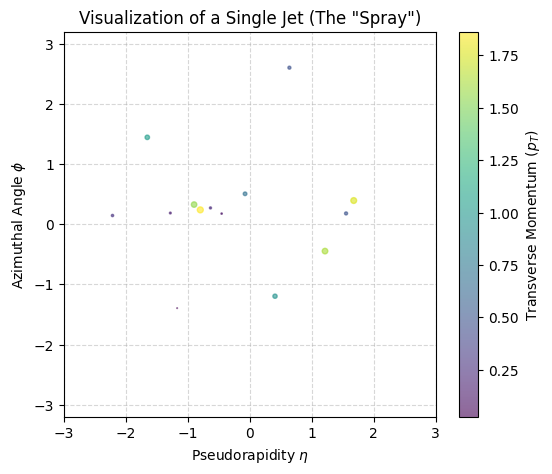

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Select the first jet (index 0)
# Shape becomes [30, 3]
jet_data = x[0]

# Extract features
# pt is column 0, eta is column 1, phi is column 2
pt = jet_data[:, 0].cpu().numpy()
eta = jet_data[:, 1].cpu().numpy()
phi = jet_data[:, 2].cpu().numpy()

# Mask out the padding (zeros) so we don't plot them
mask = pt > 0
pt = pt[mask]
eta = eta[mask]
phi = phi[mask]

# Create the plot
plt.figure(figsize=(6, 5))
# Scale the size of the dots by pT so high energy particles look bigger
plt.scatter(eta, phi, s=pt*10, alpha=0.6, c=pt, cmap='viridis')

plt.xlabel(r'Pseudorapidity $\eta$')
plt.ylabel(r'Azimuthal Angle $\phi$')
plt.title('Visualization of a Single Jet (The "Spray")')
plt.colorbar(label='Transverse Momentum ($p_T$)')
plt.grid(True, linestyle='--', alpha=0.5)

# Fix axis limits to standard detector range if needed,
# typically eta is between -3 and 3, phi is -pi to pi.
plt.xlim(-3, 3)
plt.ylim(-3.2, 3.2)

plt.show()

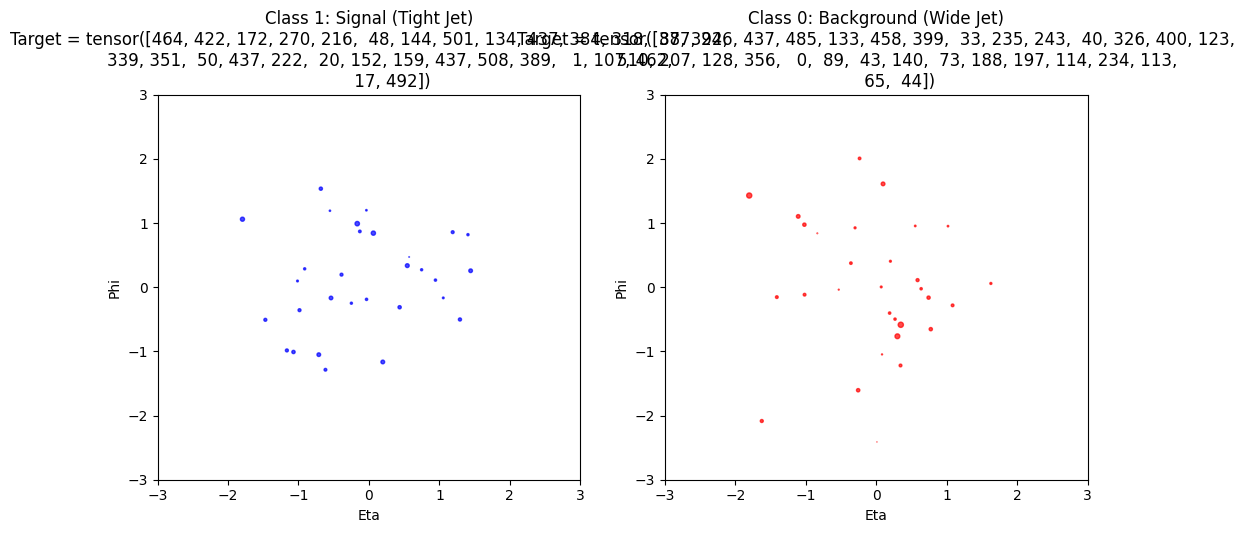

In [7]:
# Find one signal and one background index
sig_idx = (y == 1).nonzero(as_tuple=True)[0][0]
bkg_idx = (y == 0).nonzero(as_tuple=True)[0][0]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot Signal
ax[0].scatter(x[sig_idx,:,1].cpu(), x[sig_idx,:,2].cpu(), s=x[sig_idx,:,0].cpu().abs()*5, alpha=0.7, c='blue')
ax[0].set_title(f"Class 1: Signal (Tight Jet)\nTarget = {y[sig_idx].cpu()}")
ax[0].set_xlim(-3, 3); ax[0].set_ylim(-3, 3)
ax[0].set_xlabel("Eta"); ax[0].set_ylabel("Phi")

# Plot Background
ax[1].scatter(x[bkg_idx,:,1].cpu(), x[bkg_idx,:,2].cpu(), s=x[bkg_idx,:,0].cpu().abs()*5, alpha=0.7, c='red')
ax[1].set_title(f"Class 0: Background (Wide Jet)\nTarget = {y[bkg_idx].cpu()}")
ax[1].set_xlim(-3, 3); ax[1].set_ylim(-3, 3)
ax[1].set_xlabel("Eta"); ax[1].set_ylabel("Phi")

plt.show()